In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_absolute_error, r2_score
import matplotlib.pyplot as plt



In [5]:
# Load the dataset
df = pd.read_csv("/content/drive/Shareddrives/CS Ed Research/Conferences, Workshops and Presentations/2024 Fellows Folder/Workshop Files/2024.06.20 Python Workshops/Data/ames_data.csv")
original_df= df
original_df

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,1456,60,RL,62.0,7917,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,8,2007,WD,Normal,175000
1456,1457,20,RL,85.0,13175,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,MnPrv,NaN,0,2,2010,WD,Normal,210000
1457,1458,70,RL,66.0,9042,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,GdPrv,Shed,2500,5,2010,WD,Normal,266500
1458,1459,20,RL,68.0,9717,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,4,2010,WD,Normal,142125


In [8]:

# Perform data cleaning and feature engineering
df.isnull().sum().sort_values(ascending=False)[:20]


PoolQC          1453
MiscFeature     1406
Alley           1369
Fence           1179
MasVnrType       872
FireplaceQu      690
LotFrontage      259
GarageYrBlt       81
GarageCond        81
GarageType        81
GarageFinish      81
GarageQual        81
BsmtFinType2      38
BsmtExposure      38
BsmtQual          37
BsmtCond          37
BsmtFinType1      37
MasVnrArea         8
Electrical         1
Id                 0
dtype: int64

In [9]:
# Fill missing values for some features
df['LotFrontage'] = df.groupby('Neighborhood')['LotFrontage'].transform(lambda x: x.fillna(x.median()))
df['GarageYrBlt'] = df['GarageYrBlt'].fillna(df['YearBuilt'])



In [10]:
# Transform some numerical variables to categorical variables
df['MSSubClass'] = df['MSSubClass'].astype(str)
df['MoSold'] = df['MoSold'].astype(str)
df['YrSold'] = df['YrSold'].astype(str)


In [14]:
df.columns

Index(['Id', 'LotFrontage', 'LotArea', 'OverallQual', 'OverallCond',
       'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2',
       ...
       'SaleType_ConLw', 'SaleType_New', 'SaleType_Oth', 'SaleType_WD',
       'SaleCondition_Abnorml', 'SaleCondition_AdjLand',
       'SaleCondition_Alloca', 'SaleCondition_Family', 'SaleCondition_Normal',
       'SaleCondition_Partial'],
      dtype='object', length=318)

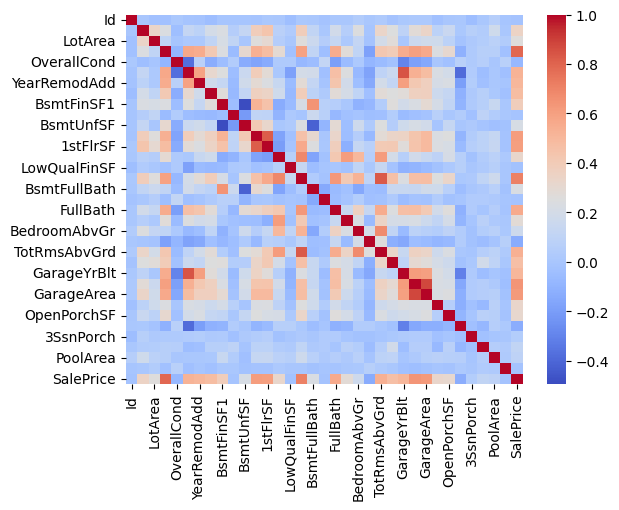

In [16]:
numerical_df = df.select_dtypes(include=['number'])

corr_matrix = numerical_df.corr()

# Plot the heatmap
sns.heatmap(corr_matrix, cmap='coolwarm')
plt.show()

In [17]:
top_7_features = corr_matrix.nlargest(7, 'SalePrice')['SalePrice']
print(top_7_features)

SalePrice      1.000000
OverallQual    0.790982
GrLivArea      0.708624
GarageCars     0.640409
GarageArea     0.623431
TotalBsmtSF    0.613581
1stFlrSF       0.605852
Name: SalePrice, dtype: float64


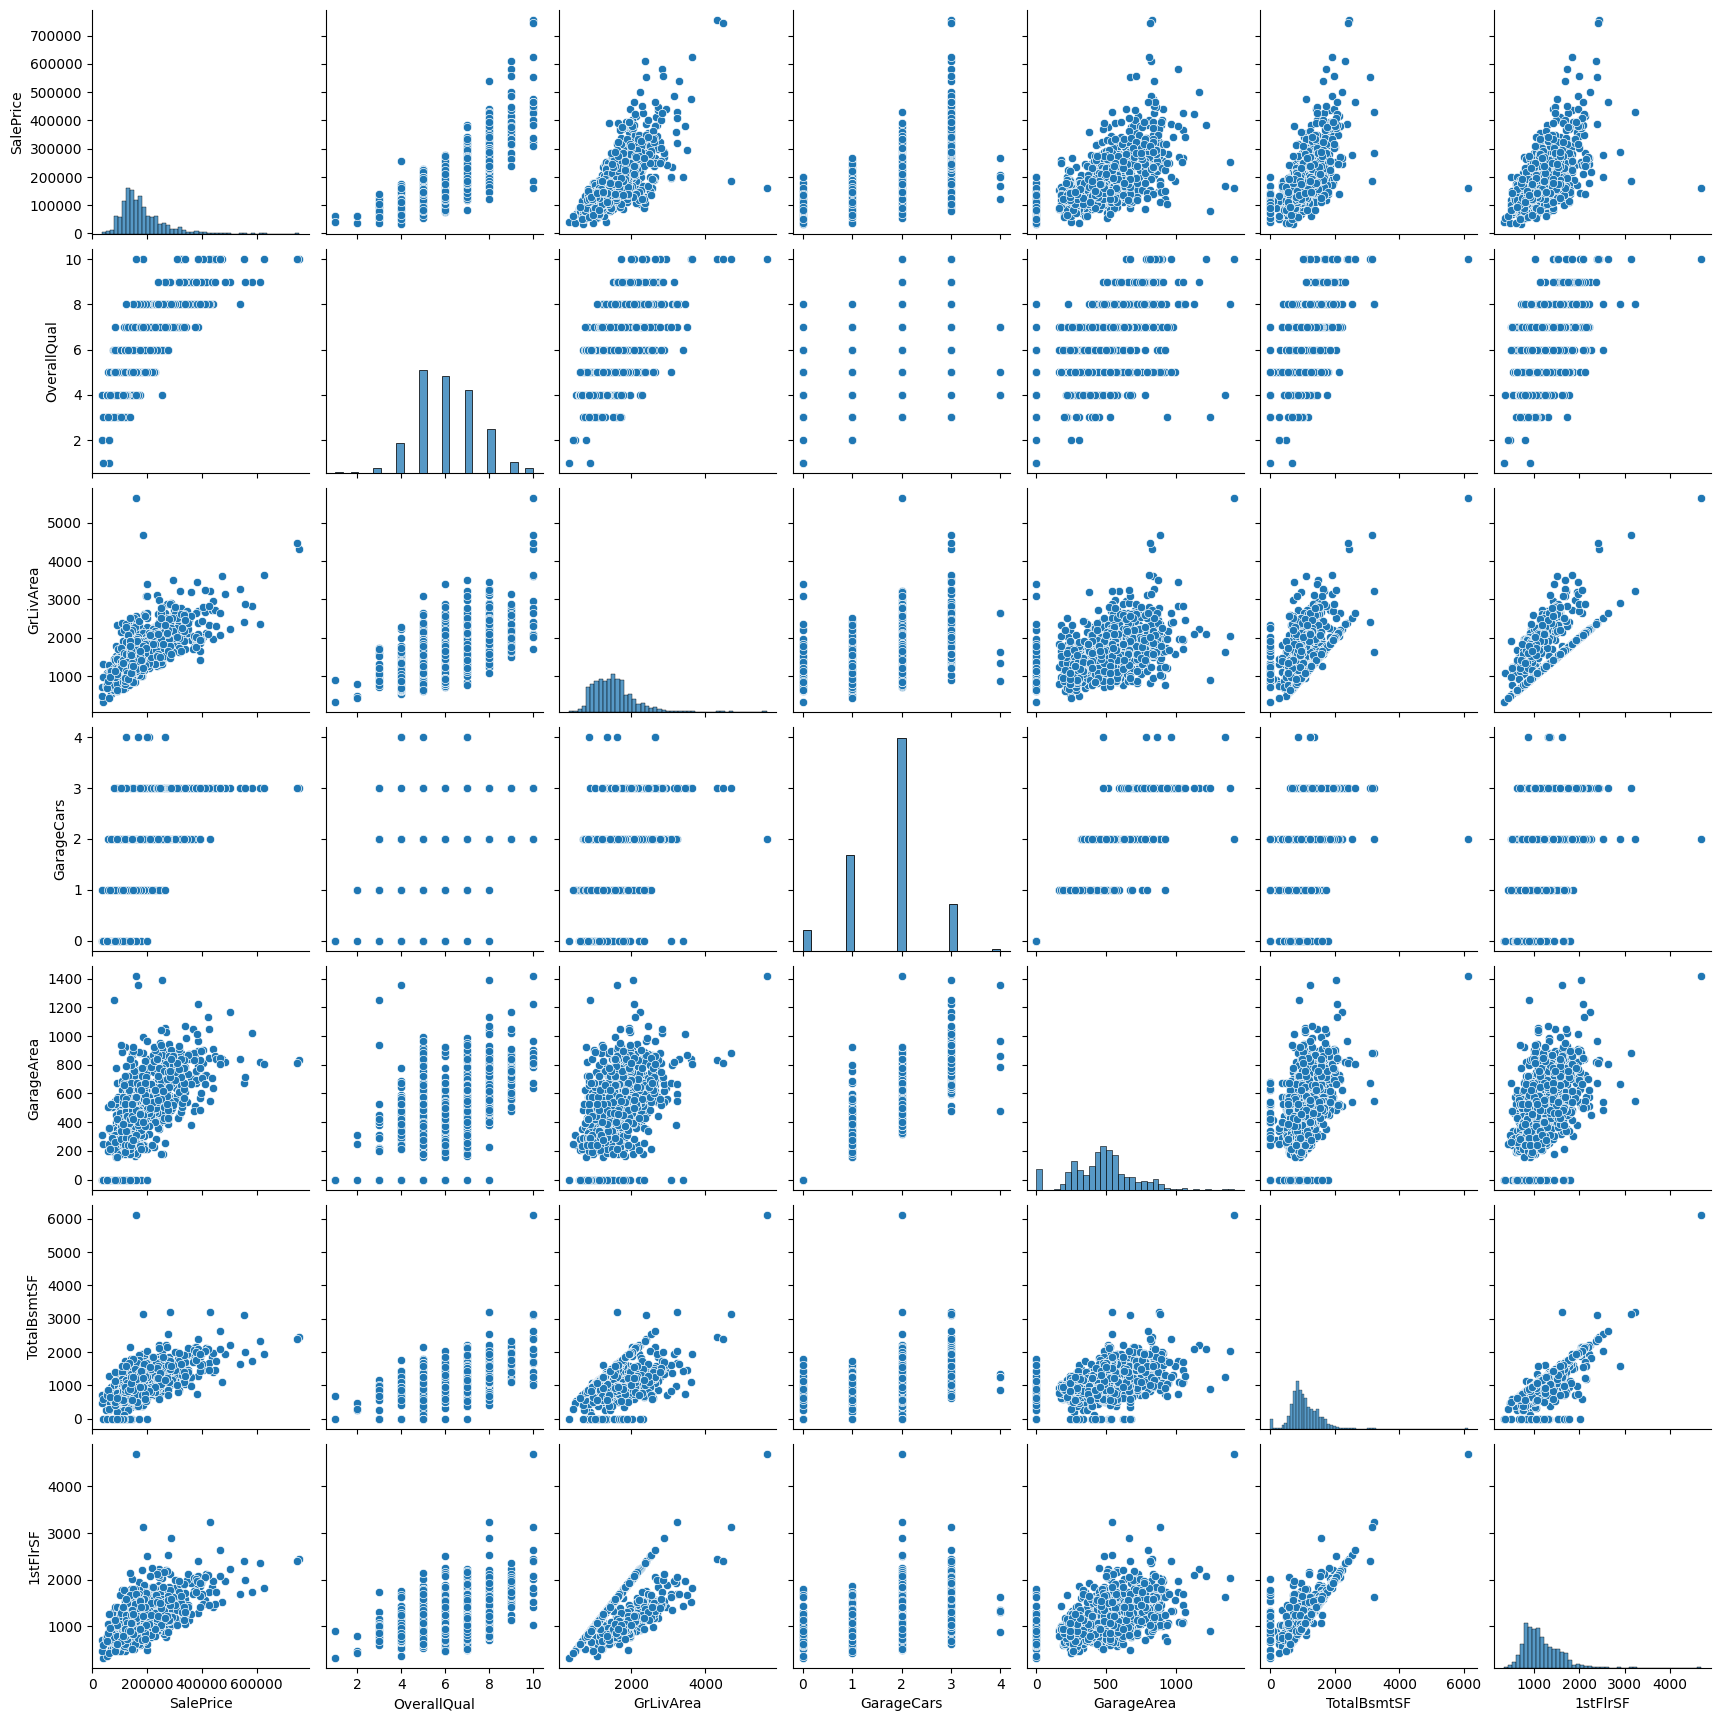

In [20]:
sns.pairplot(df[top_7_features.index])

#Outlier

In [21]:
# Remove outliers
mean_GrLivArea = df['GrLivArea'].mean()
std_GrLivArea = df['GrLivArea'].std()

z_scores = np.abs((df['GrLivArea'] - mean_GrLivArea) / std_GrLivArea)

threshold = 3

# Calculate the maximum and minimum values of the GrLivArea feature using the threshold value and the mean and standard deviation
max_GrLivArea = mean_GrLivArea + threshold * std_GrLivArea
min_GrLivArea = mean_GrLivArea - threshold * std_GrLivArea

print(f"Threshold for outlier detection in GrLivArea feature: {min_GrLivArea:.2f} - {max_GrLivArea:.2f}")

df = df[df['GrLivArea'] < max_GrLivArea]


Threshold for outlier detection in GrLivArea feature: -60.98 - 3091.90


In [22]:
# Select the most important features
#features = ['OverallQual', 'GrLivArea', 'GarageCars', 'TotalBsmtSF', 'FullBath', 'YearBuilt']
features=top_7_features

#Linear Regression

In [24]:

# Split the dataset into training and test sets
x_train, x_test, y_train, y_test = train_test_split(df[features.index], df['SalePrice'], test_size=0.2, random_state=42)


In [25]:
x_train

,SalePrice,OverallQual,GrLivArea,GarageCars,GarageArea,TotalBsmtSF,1stFlrSF
1445,129000,6,913,1,240,814,913
357,134000,5,1142,2,528,1142,1142
1100,60000,2,438,1,246,290,438
926,285000,8,2374,3,656,1181,1234
690,141000,6,848,2,420,848,848
...,...,...,...,...,...,...,...
1106,179900,7,1442,2,719,910,1442
1141,197500,5,1868,2,484,780,1088
1309,179200,6,1294,2,496,1278,1294
871,200500,6,1682,2,523,804,804


In [26]:
y_train

1445    129000
357     134000
1100     60000
926     285000
690     141000
         ...  
1106    179900
1141    197500
1309    179200
871     200500
1137     94000
Name: SalePrice, Length: 1155, dtype: int64

In [27]:
# Train and evaluate a linear regression model
lr = LinearRegression()
lr.fit(x_train, y_train)
lr_preds = lr.predict(x_test)
lr_mae = mean_absolute_error(y_test, lr_preds)
lr_r2 = r2_score(y_test, lr_preds)
print('Linear regression:')
print('MAE:', lr_mae)
print('R-squared:', lr_r2)


Linear regression:
MAE: 8.30818689508834e-12
R-squared: 1.0


#Decision Tree

In [28]:
# Train and evaluate a decision tree regressor
dt = DecisionTreeRegressor(random_state=42)
dt.fit(x_train, y_train)
dt_preds = dt.predict(x_test)
dt_mae = mean_absolute_error(y_test, dt_preds)
dt_r2 = r2_score(y_test, dt_preds)
print('Decision tree regressor:')
print('MAE:', dt_mae)
print('R-squared:', dt_r2)


Decision tree regressor:
MAE: 512.1833910034602
R-squared: 0.9979175084295716


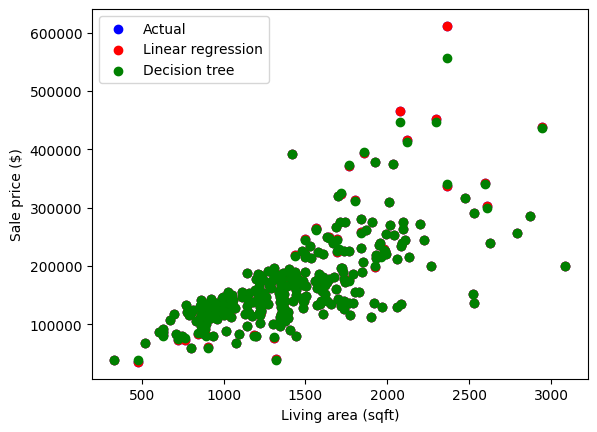

In [35]:
# Visualize the relationships between the most important features and the predicted sale prices
plt.scatter(x_test['GrLivArea'], y_test, color='blue')
plt.scatter(x_test['GrLivArea'], lr_preds, color='red')
plt.scatter(x_test['GrLivArea'], dt_preds, color='green')
#plt.scatter(X_test['GrLivArea'], rf_preds, color='orange')
plt.xlabel('Living area (sqft)')
plt.ylabel('Sale price ($)')
plt.legend(['Actual', 'Linear regression', 'Decision tree', 'Random forest'])
plt.show()

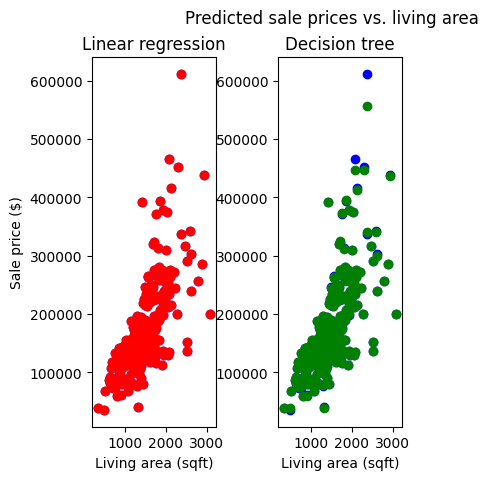

In [36]:
plt.subplot(1, 3, 1)
plt.scatter(x_test['GrLivArea'], y_test, color='blue')
plt.scatter(x_test['GrLivArea'], lr_preds, color='red')
plt.xlabel('Living area (sqft)')
plt.ylabel('Sale price ($)')
plt.title('Linear regression')

# Second subplot for decision tree
plt.subplot(1, 3, 2)
plt.scatter(x_test['GrLivArea'], y_test, color='blue')
plt.scatter(x_test['GrLivArea'], dt_preds, color='green')
plt.xlabel('Living area (sqft)')
plt.title('Decision tree')


# Set the overall title and display the plot
plt.suptitle('Predicted sale prices vs. living area')
plt.subplots_adjust(wspace=0.5)
plt.show()

In [38]:
original_df.PoolQC.value_counts()

PoolQC
Gd    3
Ex    2
Fa    2
Name: count, dtype: int64